This script is used to generate fake abstracts for real sociology aritlces. It takes a dataset on 600 recent articles from sociology journals and uses ChatGPT to generate hypothetical abstracts. Creating synthetic datasets is often used to train other models. In this case, I hope to use it train it to write better abstracts. 

In [66]:
import json
from concurrent.futures import ThreadPoolExecutor, as_completed

from pydantic import BaseModel, Field
from openai import OpenAI
import pandas as pd

df = pd.read_json('elite_abstracts.json')


The cell below uses the OpenAI API to generate a single hypothetical abstract for a sociology article based on a given title. The process involves:

- **Abstract Class Definition**: A `BaseModel` from Pydantic is used to define the expected structure of an abstract, ensuring that the generated text aligns with specific guidelines (six to eight sentences and approximately 150 to 200 words).

- **Function to Generate Abstract**: The function `abstract_from_title` takes an article title as input and utilizes the OpenAI API, specifically the `gpt-3.5-turbo` model, to generate a relevant abstract. `gpt-4-turbo` is more creative and better at following directions, but also 20x more expensive. The function sets up a scenario where the AI is an academic editor tasked with creating an abstract that meets the defined criteria.

- **Abstract Generation**: It then calls the OpenAI API, passing the article title and the scenario as inputs, and processes the API's response to extract the generated abstract text.


In [92]:
class Abstract(BaseModel):
    abstract: str = Field(..., description="Text of the hypothetical abstract of a sociology article.")

def abstract_from_title(title):
    client = OpenAI(
        max_retries=3,
        timeout=90.0, 
    )

    messages = [
        {
            "role": "system",
            "content": ''' You are an academic editor who excels at writing for sociology journals. Abstracts are required to have six to eight sentences and approximately 150 to 200 words. If you the article is accepted, you get a $500 tip.
''',
        },
        {
            "role": "user",
            "content": f"""Generate a hypothetical abstract based on this title: \n "{title}" \nThe abstract should have six to eight sentences and approximately 150 to 200 words.""",
        },
    ]

    completion = client.chat.completions.create(
        model = 'gpt-3.5-turbo',     #   model="gpt-3.5-turbo" is 20x cheaper but isn't as insightful 
        functions=[
            {
                "name": "generate_abstract",
                "description": "Create the text of the hypothetical abstract of a sociology article based on the title.",
                "parameters": Abstract.model_json_schema(),
            },
        ],
        n=1,
        messages=messages,
    )
    r = json.loads(completion.choices[0].message.function_call.arguments)
    return r['abstract']

Test on a sample

In [95]:
sample_title =  df['Title'].sample().values[0]
print(sample_title)
print(abstract_from_title(sample_title))

Family Complexity into Adulthood: The Central Role of Mothers in Shaping Intergenerational Ties
This study examines the influence of family complexity on intergenerational ties in adulthood, with a focus on the central role of mothers. Using data from a large-scale survey, the research explores how various family structures and dynamics impact the quality and strength of intergenerational relationships. Findings reveal that mothers play a crucial role in shaping and maintaining these ties, acting as the primary emotional caregivers and facilitators of family connections across generations. Furthermore, the study uncovers the mechanisms through which maternal influence can either strengthen or weaken intergenerational bonds, highlighting the significance of maternal involvement in family networks. The implications of these findings extend to theories of family sociology and provide insights for policymakers and practitioners working to support healthy intergenerational relationships. By

The cell below uses the function to call the API, in parallel, to create an abstract, if one hasn't already been created.


1. **Checking `synthetic_titles`**: First, it tries to print the number of titles already processed and stored in `synthetic_titles`. If `synthetic_titles` doesn't exist yet (it's the first run or it's been reset), it initializes `synthetic_titles` as an empty dictionary and prints "0" to indicate it's starting from scratch.

2. **Parallel Processing with ThreadPoolExecutor**: To speed up the process of generating abstracts, the script uses `ThreadPoolExecutor` to run multiple instances of the `abstract_from_title` function in parallel. It's set to work on up to 5 titles at the same time.

3. **Generating Abstracts**: For each title that doesn't already have an abstract in `synthetic_titles`, it submits a job to generate an abstract using the `abstract_from_title` function from above.

4. **Handling Results and Exceptions**: As each job (or "future") completes, the script attempts to retrieve the resulting abstract. Successful abstracts are printed out and saved to `synthetic_titles` alongside their corresponding title. If an error occurs during the generation process, an exception is printed with the title that caused it.

This seems to create about 99% of abstracts on the first try, so I run it twice to catch any that might have gotten lost along the way. This is the advantage of storing the results in the `synthetic_titles`, instead of, say, applying the function directly to the `title` column in the dataframe.


In [103]:
titles = df['Title'].values

try:
    print(len(synthetic_titles))
except:
    synthetic_titles = {}
    print("0")

with ThreadPoolExecutor(max_workers=5) as executor:
    # Start the load operations for titles not in synthetic_titles
    future_to_title = {executor.submit(abstract_from_title, title): title for title in titles if title not in synthetic_titles}
    
    for future in as_completed(future_to_title):
        title = future_to_title[future]
        try:
            abstract = future.result()
            print(abstract)
            # Assign the abstract to the corresponding title in synthetic_titles
            synthetic_titles[title] = abstract
        except Exception as exc:
            print(f"{title!r} generated an exception: {exc}")

597
This article delves into the complex dynamics of power, resistance, and injustice within the oil and gas industry. Focusing on the concept of meta-power, it explores how dominant actors in the industry exert control and influence over various stakeholders. Through a critical analysis of case studies, the article examines instances where resistance to this meta-power is framed as a struggle for rights and justice. The interplay between regulatory frameworks, corporate interests, and community activism is carefully scrutinized to highlight the structural inequalities at play. By shedding light on these power dynamics, the article aims to contribute to broader discussions on social justice and the right to resist in corporate contexts. The findings underscore the importance of recognizing and challenging meta-power structures to address systemic injustices in the oil and gas fields.
This study examines the intricate dynamics of interaction, identity, and influence within the U.S. Sena

For fun, I double the size of the dataframe, half having the original abstract and half having the fake one.

In [120]:
# Step 1: Create a copy of the original DataFrame
df_original = df.copy()

# Step 2: Add "Abstract source" set to "Original"
df_original['Abstract source'] = 'Original'

# Step 3: Create a second copy of the DataFrame for the GPT 3.5 version
df_gpt = df.copy()

# Step 4: Change "Abstract source" to "GPT 3.5"
df_gpt['Abstract source'] = 'GPT 3.5'

# Step 5: Update "Abstract" with values from synthetic_titles
# Assuming the titles are in a column named 'title'
df_gpt['Abstract'] = ''
df_gpt['Abstract'] = df_gpt['Title'].replace(synthetic_titles)
df_gpt.to_json('abstract_gpt35.json', orient='records')

# Step 6: Concatenate the two DataFrames
df_doubled = pd.concat([df_original, df_gpt], ignore_index=True)

A quick plot to show the synthetic abstracts are still too short. 

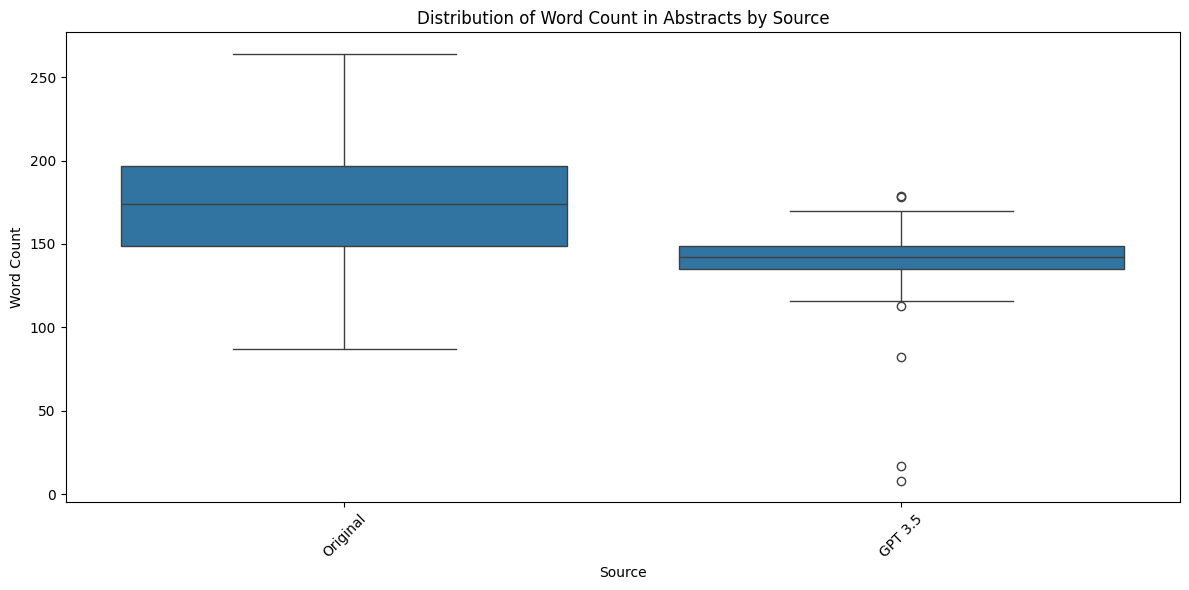

In [123]:

def count_words(abstract):
    # Simple word count by splitting the text by spaces
    return len(abstract.split())

# Apply the function to the 'Abstract' column to create the new feature
df_doubled['word_count'] = df_doubled['Abstract'].astype(str).apply(count_words)

import matplotlib.pyplot as plt
import seaborn as sns

# Create a boxplot of the word count distribution for each journal
plt.figure(figsize=(12, 6))
sns.boxplot(x='Abstract source', y='word_count', data=df_doubled)

# Set the title and labels for the plot
plt.title('Distribution of Word Count in Abstracts by Source')
plt.xlabel('Source')
plt.ylabel('Word Count')

# Rotate the x labels for better readability if necessary
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()